In [1]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


mse = nn.MSELoss()
# torch.manual_seed(24)

# system model parameters
MAX_EP_LEN=125
OBJECTIVE=24
IMG_DIM=64

In [2]:
# load data
snr_samples = np.load('data/snr_data.npy')
rand = np.random.choice(len(snr_samples), len(snr_samples), replace=False)
snr_train, snr_test = snr_samples[rand[:20]], snr_samples[rand[20:]]

(64, 64)


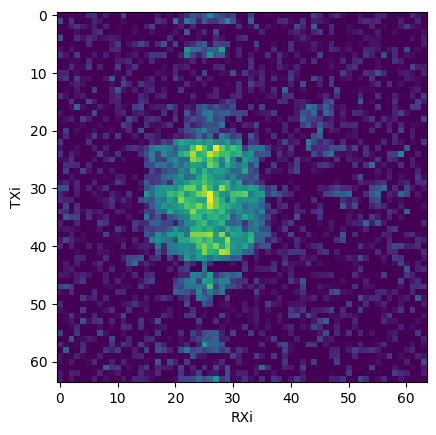

In [3]:
# data augmentation
def sample_data(train=True, window=16, noise=0.1, rotate=True, mirror=True, img_dim=IMG_DIM):
    data_dim=70 # dataset parameter
    d = snr_train if train else snr_test # train / test
    s = d[np.random.randint(len(d))] # get sample frame
    # window shift
    shft = window - (1+data_dim-img_dim)//2
    s = np.vstack([s[-shft:],s,s[:shft]])
    s = np.hstack([s[:,-shft:],s,s[:,:shft]])
    sx, sy = np.random.randint(2*window), np.random.randint(2*window)
    s = s[sx:img_dim+sx,sy:img_dim+sy]
    # add noise
    s += noise*np.random.randn(img_dim,img_dim)
    s = np.clip(s, 0, 1)
    # rotation
    if rotate:
        s = np.rot90(s, k=np.random.randint(4), axes=(0,1))
    # mirror
    m = np.random.randint(3)
    if mirror and m != 2:
        s = np.flip(s, axis=m)
    return s

def sample_batch(batch_size=16, train=True, window=16, noise=0.1, rotate=True, mirror=True, single_env=False):
    if single_env:
        x = sample_data(train=train, window=window, noise=noise, rotate=noise, mirror=noise)
        return np.array([np.copy(x) for _ in range(batch_size)])
    return np.array([sample_data(train=train, window=window, noise=noise, rotate=noise, mirror=noise) for _ in range(batch_size)])

# show a sample
print(sample_data().shape)
plt.imshow(sample_data())
plt.xlabel("RXi")
plt.ylabel("TXi")
plt.show()

In [4]:
# U-net architecture for sparse input
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, parity):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.down_conv(x)
    
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, u_channels, parity):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.norm_conv = nn.Sequential(
            nn.Conv2d(in_channels + u_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x1, x2):
        return self.norm_conv(torch.cat([self.upsample(x1), x2], dim=1))

class UNet(nn.Module):
    def __init__(self, activ='relu', enc_dim=256):
        super().__init__()
        if activ=="relu":
            ll = nn.ReLU()
        elif activ=="softmax":
            ll=nn.Softmax(dim=1)
        elif activ=="tanh":
            ll=nn.Tanh()
        elif activ=="elu":
            ll=nn.ELU()
        
        self.dc1 = DownConv(2, 2, 'even') # 32x32 ---┐ |
        self.dc2 = DownConv(2, 4, 'odd') # 16x16   ┐ | |
        self.dc3 = DownConv(4, 8, 'even') # 8x8    | | |
                                           #       | | |        
        self.uc1 = UpConv(8, 4, 4, 'even') # 16x16 ┘ | |
        self.uc2 = UpConv(4, 2, 2, 'odd') # 32x32 ---┘ |
        self.uc3 = UpConv(2, 2, 2, 'even') # 64x64 ----┘
        
        self.enc_head = nn.Sequential(
            nn.Linear(8*8*8 + 1, enc_dim),
            nn.Sigmoid(),
        )
        
        self.dec_lin = nn.Sequential(
            nn.Linear(enc_dim, 8*8*8),
            nn.ReLU(),
        )
        
        self.dec_head = nn.Sequential(
            nn.Conv2d(2, 2, 3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(2, 1, 3, stride=1, padding=1, bias=False),
            nn.Flatten(start_dim=1),
            ll,
            nn.Unflatten(1, (1,IMG_DIM,IMG_DIM)),
        )
        
        self.scalar_head = nn.Sequential(
            nn.Linear(enc_dim, 1),
            # nn.Sigmoid(),
        )
        
    def encoder(self, x0, t):
        shape = x0.shape[:-3]
        x0 = torch.flatten(x0, end_dim=-4)
        x1 = self.dc1(x0)
        x2 = self.dc2(x1)
        x = self.dc3(x2)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat([x, t.flatten().unsqueeze(1)], dim=1)
        x = self.enc_head(x)
        return x, x0, x1, x2, shape
        
    def decoder(self, x, x0, x1, x2, shape):
        x = self.dec_lin(x).view(-1,8,8,8)
        x = self.uc1(x, x2)
        x = self.uc2(x2, x1)
        x = self.uc3(x1, x0)
        x = self.dec_head(x)
        return x.view(*shape, *x.shape[1:])

    def forward(self, x0, t):
        return self.decoder(*self.encoder(x0, t))

    def forward_scalar(self, x0, t):
        x, x0, x1, x2, shape = self.encoder(x0, t)
        x = self.scalar_head(x)
        return x.view(*shape, *x.shape[1:])

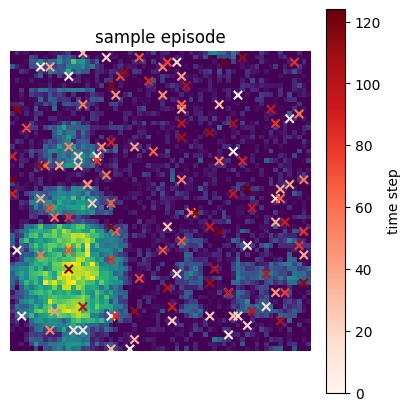

In [5]:
# random policy
def move(s,x,i,img_dim=IMG_DIM):
    m = x[:,1].unsqueeze(1)
    m[torch.arange(x.shape[0]),:,i//img_dim,i%img_dim] = 1
    x = torch.cat([s*m,m], dim=1)
    return x
    
def sample_move(actor_eval):
    shape = actor_eval.shape[:-3]
    actor_eval = torch.flatten(actor_eval, end_dim=-4)
    mv = torch.Tensor([torch.multinomial(torch.flatten(ev),1)[0] for ev in actor_eval]).long()
    return mv.view(*shape, *mv.shape[1:])

def determ_move(actor_eval):
    return torch.argmax(torch.flatten(actor_eval, start_dim=-3), dim=1)

def rand_move(batch_size, img_dim=IMG_DIM):
    return torch.randint(0, img_dim*img_dim, (batch_size,))

def sxy_sample(batch_size, train=True, single_env=False):
    s = torch.Tensor(sample_batch(batch_size=batch_size, train=train, single_env=single_env)).unsqueeze(1)
    x = torch.cat([torch.zeros_like(s), torch.zeros_like(s)], dim=1)
    y = torch.argmax(torch.flatten(s, start_dim=1), dim=1)
    return s, x, y

def gen_episodes(policy, n_ep, ep_len, train=True, single_env=False, img_dim=IMG_DIM):
    s, x, y = sxy_sample(n_ep, train=train, single_env=single_env)
    fm = rand_move(n_ep)
    x = move(s, x, fm)
    ep_hist, mv_hist, rw_hist = [x], [], []
    cum_rw = torch.zeros(n_ep)
    with torch.no_grad():
        for i in range(ep_len):
            mv = policy(x, cum_rw / OBJECTIVE)
            x = move(s, x, mv)
            rw = s[torch.arange(n_ep),:,mv//img_dim,mv%img_dim]
            cum_rw += rw.view(n_ep)
            ep_hist.append(x), mv_hist.append(mv), rw_hist.append(rw)
    ep_hist = torch.cat([x.unsqueeze(1) for x in ep_hist], dim=1) # n_ep x ep_len
    mv_hist = torch.cat([x.unsqueeze(1) for x in mv_hist], dim=1)
    rw_hist = torch.cat([x.unsqueeze(1) for x in rw_hist], dim=1)
    return ep_hist, mv_hist.view(n_ep,ep_len), rw_hist.view(n_ep,ep_len), s

def simulate_search(policy_dict, n=200, ep_len=MAX_EP_LEN):
    fig, ax = plt.subplots(figsize=(4,4), layout="constrained")
    # plot mean reward over time
    ax.set_title("reward over episode")
    ax.set_ylabel("reward")
    ax.set_xlabel("time step")

    for name in policy_dict:
        ep_hist, mv_hist, rw_hist, s = gen_episodes(policy_dict[name], n, ep_len)
        rw_bar = torch.cumsum(torch.cat([torch.zeros(1), rw_hist.mean(dim=0)], dim=0), dim=0) > OBJECTIVE
        rw_bar = torch.logical_and(rw_bar[1:], torch.logical_not(rw_bar[:-1])).long()
        print(name+' mean rw: ',rw_bar.max(dim=0).indices.item())
        ax.plot(rw_hist.mean(axis=0), label=name)
        ax.bar(np.arange(len(rw_bar)), rw_bar, width=1, label=name+' end')
        
    ax.legend()
    plt.show()
    
def viz_search(policy, ep_len=MAX_EP_LEN, img_dim=IMG_DIM):
    fig, ax = plt.subplots(figsize=(4,4), layout="constrained")

    # plot example search
    ep_hist, mv_hist, rw_hist, s = gen_episodes(policy, 1, ep_len)
    sc = ax.scatter(mv_hist[0]%img_dim, mv_hist[0]//img_dim, marker='x', c=np.arange(ep_len), cmap="Reds")
    
    ax.set_title("sample episode")
    ax.imshow(s[0].squeeze())
    ax.axis("off")
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("time step")
    plt.show()
    
def rand_policy(x, t):
    return rand_move(x.shape[0])
    
viz_search(rand_policy)

In [6]:
def sample_bank(batch_size, ep_hist, rw_hist, s_hist):
    eps, ep_len = ep_hist.shape[0], ep_hist.shape[1]-1
    ep = torch.randint(0, eps, (batch_size,))
    t = torch.randint(0, ep_len, (batch_size,))
    x = ep_hist[ep,t]
    r = rw_hist[ep,t]
    s = s_hist[ep]
    return x, r, s

# basic supervised training loop
def pretrain(
        model,
        lr=3e-4, # https://twitter.com/karpathy/status/801621764144971776?s=20
        iterations=2.5e3,
        n_ep=600,
        batch_size=64,
        eval_freq=1e2,
        print_freq=5e2,
        ):
    optim = torch.optim.Adam(base.parameters(), lr=lr)
    
    # get data
    ep_hist, _, rw_hist, s = gen_episodes(lambda x, t: rand_move(x.shape[0]), n_ep, MAX_EP_LEN, train=True)
    ep_hist_test, _, rw_hist_test, s_test = gen_episodes(lambda x, t: rand_move(x.shape[0]), n_ep, MAX_EP_LEN, train=False)
    rw_hist_cum = torch.cumsum(torch.cat([torch.zeros(n_ep,1), rw_hist[:,:-1]], dim=1), dim=1) / OBJECTIVE
    rw_hist_test_cum = torch.cumsum(torch.cat([torch.zeros(n_ep,1), rw_hist_test[:,:-1]], dim=1), dim=1) / OBJECTIVE
    
    # main loop
    train_hist, eval_hist = [], []
    for i in range(int(iterations)):
        # get data
        x, r, y = sample_bank(batch_size, ep_hist, rw_hist_cum, s)
        # update model
        optim.zero_grad()
        p = model(x,r)
        l = mse(p,y)
        l.backward()
        optim.step()
        train_hist.append(l.detach().item())
        # eval and logging
        if i%eval_freq == eval_freq-1:
            with torch.no_grad():
                x, r, y = sample_bank(batch_size, ep_hist_test, rw_hist_test_cum, s_test)
                p = model(x,r)
                l = mse(p,y)
                eval_hist.append(l.item())
        if i%print_freq == print_freq-1:
            print(f"iter {i+1:>6}:  train_loss={train_hist[-1]:>5.4f}  eval_loss={eval_hist[-1]:>5.4f}")
    return train_hist, eval_hist

In [7]:
# base model pre-training
iterations = 2.5e3

# model
base = UNet()
train_hist, eval_hist = pretrain(base, iterations=iterations)

# save model
torch.save(base.state_dict(), "models/base.torch")

iter    500:  train_loss=0.0350  eval_loss=0.0285
iter   1000:  train_loss=0.0357  eval_loss=0.0267
iter   1500:  train_loss=0.0328  eval_loss=0.0251
iter   2000:  train_loss=0.0304  eval_loss=0.0256
iter   2500:  train_loss=0.0355  eval_loss=0.0248


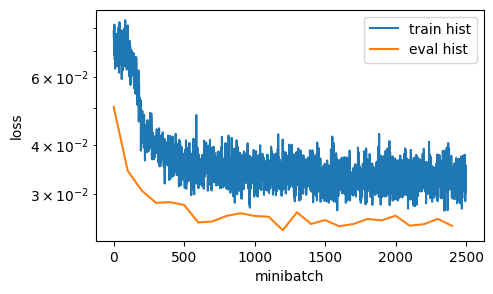

In [8]:
def plot_train_hist(train_hist, eval_hist):
    eval_freq = len(train_hist) / len(eval_hist)
    fig, ax = plt.subplots(figsize=(5,3))

    ax.plot(np.arange(0, len(train_hist), 1), train_hist, label='train hist')
    ax.plot(np.arange(0, len(train_hist), eval_freq), eval_hist, label='eval hist')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('minibatch')
    ax.set_ylabel('loss')
    plt.show()
    
plot_train_hist(train_hist, eval_hist)

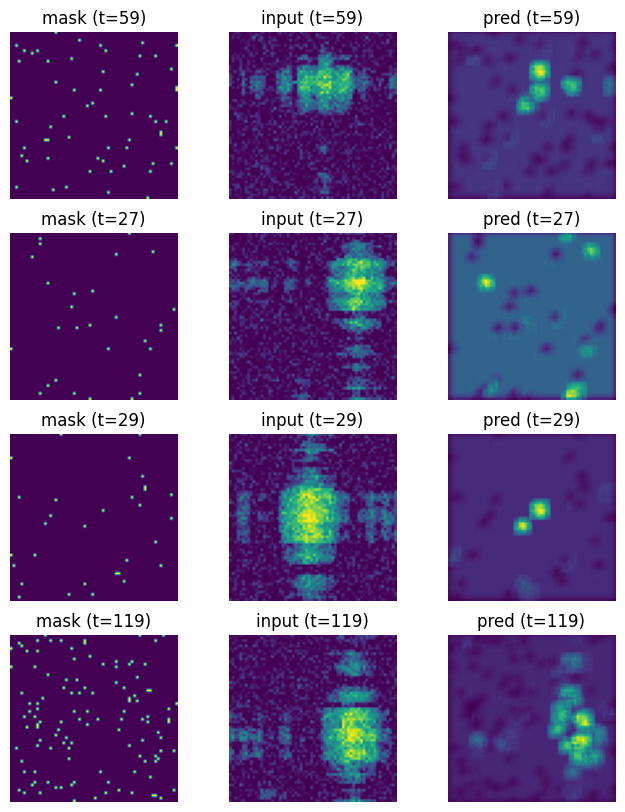

In [7]:
# visualize results
def viz_sim(model, policy, n_viz=4, ep_len=MAX_EP_LEN):
    ep_hist, mv_hist, rw_hist, s = gen_episodes(policy, n_viz, ep_len)
    cum_rw = torch.cumsum(torch.cat([torch.zeros(n_viz,1), rw_hist], dim=1), dim=1) / OBJECTIVE
    with torch.no_grad():
        preds = model(ep_hist[:,:-1], cum_rw[:,:-1])

    fig, axs = plt.subplots(n_viz, 3, figsize=(8,10))
    for (ax1, ax2, ax3), x, y, pred in zip(axs, ep_hist, s, preds):
        i = np.random.randint(ep_len)
        ax1.imshow(x[i,1].numpy())
        ax2.imshow(y.squeeze().numpy())
        ax3.imshow(pred[i].squeeze().numpy())
        ax1.set_title(f"mask (t={i})"), ax2.set_title(f"input (t={i})"), ax3.set_title(f"pred (t={i})")
        ax1.axis("off"), ax2.axis("off"), ax3.axis("off") 

    plt.show()
    
base = UNet()
base.load_state_dict(torch.load("models/base.torch"))
viz_sim(base, rand_policy)

greedy det mean rw:  93


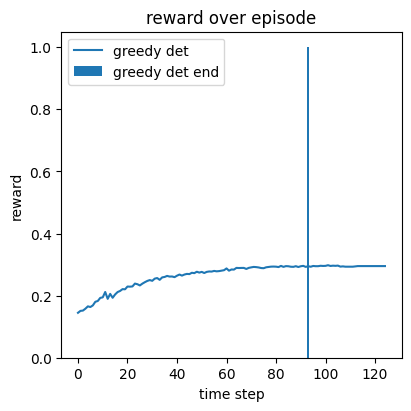

In [8]:
# greedy simulation
def greedy_policy_det(actor):
    def policy(x, r):
        with torch.no_grad():
            return determ_move(actor(x, r*torch.ones(x.shape[0])))
    return policy

def greedy_policy_sto(actor):
    def policy(x, r):
        with torch.no_grad():
            return sample_move(actor(x, r*torch.ones(x.shape[0])))
    return policy


simulate_search({'greedy det':greedy_policy_det(base)})

Best t_explore: 0.2105


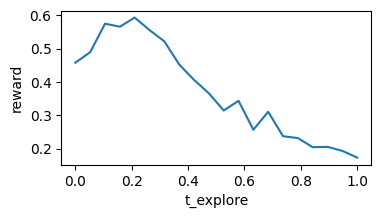

In [9]:
def base_rand_explore_policy(x, r, mu=0.2, sig=0.05):
    n = x.shape[0]
    if isinstance(r, float):
        r = r*torch.ones(n)
    with torch.no_grad():
        base_mv = determ_move(base(x, r))
    rand_mv = rand_move(n)
    rand = (r < mu + sig*torch.randn(n)).long()
    return rand_mv*rand + base_mv*(1-rand)

# what is best t_explore value?
n = 100
ts = np.linspace(0,1,20)
rews = []
for te in ts:
    ep_hist, mv_hist, rw_hist, s = gen_episodes(lambda x,r: base_rand_explore_policy(x,r,te), n, MAX_EP_LEN)
    rews.append(rw_hist.mean().item())

print(f"Best t_explore: {ts[np.argmax(rews)]:.4f}")
    
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(ts, rews)
ax.set_xlabel('t_explore')
ax.set_ylabel('reward')
plt.show()

base fixed k mean rw:  57


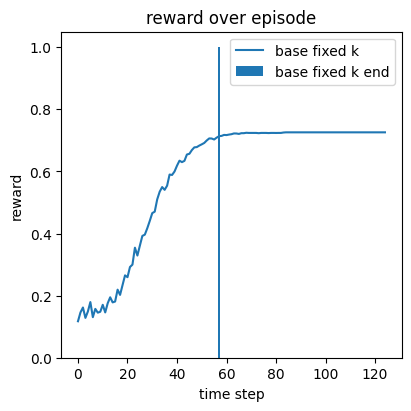

In [10]:
simulate_search({'base fixed k':base_rand_explore_policy})

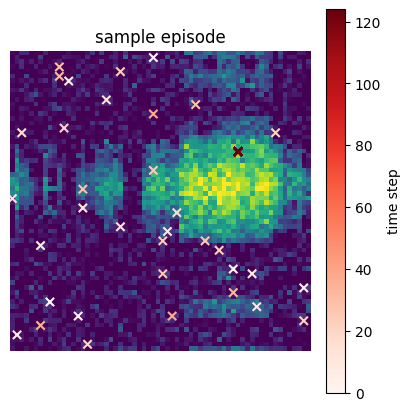

In [11]:
viz_search(base_rand_explore_policy)

In [ ]:
def sample_bank(batch_size, ep_hist, cum_rw_hist, mv_hist, rw_hist, p_hist):
    eps, ep_len = ep_hist.shape[0], ep_hist.shape[1]-1
    ep = torch.randint(0, eps, (2*batch_size,))
    t = torch.randint(0, ep_len, (2*batch_size,))
    mask = cum_rw_hist[ep,t]<1
    ep, t = ep[mask][:batch_size], t[mask][:batch_size] # only learn while episode is still running
    x0 = ep_hist[ep,t]
    x1 = ep_hist[ep,t+1]
    r0 = cum_rw_hist[ep,t]
    r1 = cum_rw_hist[ep,t+1]
    mv = mv_hist[ep,t].long()
    cum_rw = cum_rw_hist[ep,t]
    rw = rw_hist[ep,t]
    p_old = p_hist[ep,t]
    return (x0, r0), (x1, r1), mv, rw, p_old

def index_policy(batch, i):
    n = i.shape[0]
    return batch.view(n,-1)[torch.arange(n),i]

def entropy(batch):
    p = torch.flatten(batch, start_dim=2)
    return -(p*torch.log(torch.clip(p, min=1e-4))).sum(dim=2).mean()

def PPO(
        use_critic=False,
        lr=1e-4,
        epochs=200,
        updates_per_epoch=120,
        ep_batch=160,
        batch_size=48,
        eps=0.2, # clipping amount for PPO
        beta=1e-3, # entropy regularization
        gamma=0.95, # off policy exploration
        print_freq=20,
    ):
    gamma_lim = 1/(1-gamma)
    
    # init policy + critic
    policy = UNet(activ="softmax")
    policy.load_state_dict(torch.load("models/base.torch"))
    
    # optimizers (fine-tuning)
    # policy_optim = torch.optim.Adam(policy.dec_head.parameters(), lr=lr) # 0.23
    policy_optim = torch.optim.Adam([
        {'params':policy.dec_lin.parameters()},
        {'params':policy.uc1.parameters(), 'lr':1e-5},
        {'params':policy.uc2.parameters(), 'lr':1e-5},
        {'params':policy.uc3.parameters(), 'lr':1e-5},
        {'params':policy.dec_head.parameters()},
    ], lr=lr)
    critic_optim = torch.optim.Adam(policy.scalar_head.parameters(), lr=lr)
    
    # PPO
    rw_log, ent_log = [], []
    for epoch in range(epochs):
        # sample collection
        ep_hist, mv_hist, rw_hist, s_hist = gen_episodes(greedy_policy_sto(policy), ep_batch, MAX_EP_LEN)
        cum_rw = torch.cumsum(torch.cat([torch.zeros(ep_batch,1), rw_hist], dim=1), dim=1) / OBJECTIVE # cumulative rw for model input
        lt_obj = (cum_rw < 1).float() # {0,1} rw accumulated each step
        cum_disc_obj = torch.zeros(ep_batch, MAX_EP_LEN) # discounted cumulative lt_obj
        for i in range(MAX_EP_LEN):
            cum_disc_obj[:,-1-i] = lt_obj[:,-1-i] + gamma * cum_disc_obj[:,-i]
        
        with torch.no_grad():
            p_hist = policy(ep_hist, cum_rw) # get policy probas for surrogate loss
            
        if use_critic:
            # update critic
            for i in range(updates_per_epoch):
                # x0, x1, mv, rw, p = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, lt_obj, p_hist)
                x0, x1, mv, rw, p_old = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, cum_disc_obj, p_hist)
                critic_optim.zero_grad()
                # r0, r1 = policy.forward_scalar(*x0).squeeze(), critic.forward_scalar(*x1).squeeze()
                # L = mse(r0, rw/gamma_lim + gamma * r1) # bellman
                r0 = policy.forward_scalar(*x0).squeeze()
                L = mse(r0, rw/gamma_lim) # manual rollback

                L.backward()
                critic_optim.step()

            # calculate advantage
            with torch.no_grad():
                rw_est = policy.forward_scalar(ep_hist, cum_rw)
            adv_hist = rw_est[:,:-1]-rw_est[:,1:] # backwards because minimization problem
        else:
            # calculate advantage
            adv_hist = cum_disc_obj[:,:-1] - cum_disc_obj[:,1:] # backwards because minimization problem
            adv_hist = torch.cat([adv_hist[:,0].unsqueeze(1), adv_hist], dim=1)
        
        # update policy
        for i in range(updates_per_epoch):
            x0, x1, mv, rw, p_old = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, adv_hist, p_hist)
            policy_optim.zero_grad()
            p = policy(*x0)
            r = index_policy(p, mv) / torch.clip(index_policy(p_old, mv), min=1e-4) # ratio of policies
            r_clipped = torch.clip(r, min=1-eps, max=1+eps) # clip ratio
            ent = entropy(p) # prediction entropy
            L = torch.minimum(r*rw, r_clipped*rw).mean() + beta*ent # surrogate loss
            L.backward()
            policy_optim.step()
            
        # logging
        rw_log.append(1-lt_obj.mean().item())
        ent_log.append(ent.detach().item())
        if epoch%print_freq == print_freq-1:
            print(f"epoch {epoch+1:>6}:  reward={sum(rw_log[-print_freq:])/print_freq:>5.4f}")
            torch.save(policy.state_dict(), "models/ppo_policy.torch")
        
    return rw_log, ent_log

rw_log, ent_log = PPO()

base fixed k mean rw:  57
ppo mean rw:  72


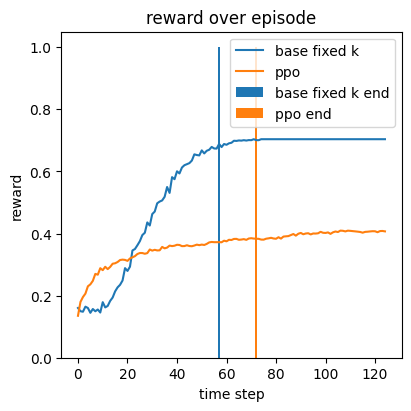

In [13]:
ppo = UNet(activ="softmax")
ppo.load_state_dict(torch.load("models/ppo_policy.torch"))
simulate_search({'base fixed k':base_rand_explore_policy, 'ppo':greedy_policy_sto(ppo)})

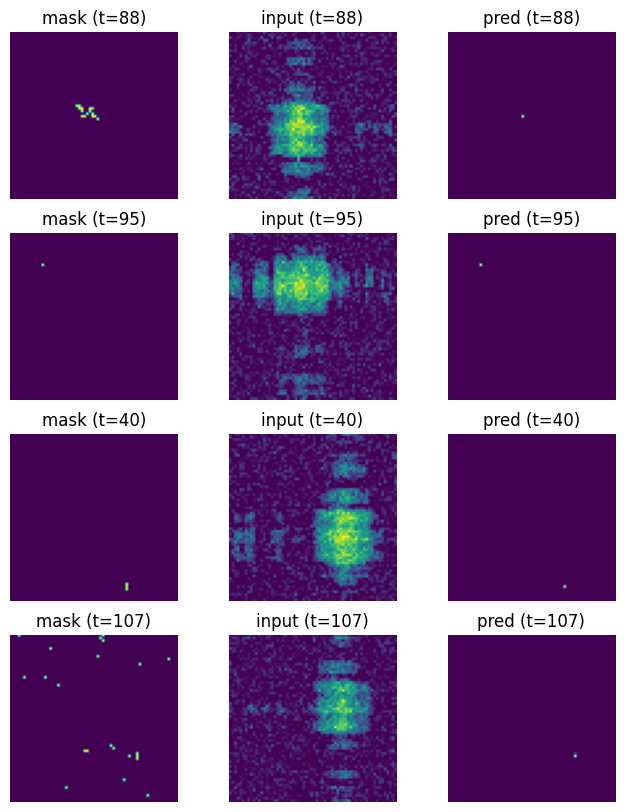

In [14]:
viz_sim(ppo, greedy_policy_sto(ppo))

In [ ]:
def dynamic_rand_explore_policy(exploit_fn, sig=0.05, min_explore=0.1, max_explore=0.4):
    def policy(x,r):
        n = x.shape[0]
        if isinstance(r, float):
            r = r*torch.ones(n)
        with torch.no_grad():
            p = torch.sigmoid(exploit_fn(x,r).squeeze())
            p[r<min_explore] = 0
            p[r>max_explore] = 1
             
            explore = rand_move(n)
            exploit = determ_move(base(x, r))
            
            rand = (torch.rand(n)<p).long()
        return explore * (1-rand) + exploit * rand
    return policy

def sample_bank(batch_size, ep_hist, cum_rw_hist, mv_hist, rw_hist, k_hist, exploit_hist, min_explore, max_explore):
    eps, ep_len = ep_hist.shape[0], ep_hist.shape[1]-1
    ep = torch.randint(0, eps, (2*batch_size,))
    t = torch.randint(0, ep_len, (2*batch_size,))
    mask = torch.logical_and(cum_rw_hist[ep,t]>min_explore, cum_rw_hist[ep,t]<max_explore)
    ep, t = ep[mask][:batch_size], t[mask][:batch_size] # only learn in mixed policy range
    x0 = ep_hist[ep,t]
    x1 = ep_hist[ep,t+1]
    r0 = cum_rw_hist[ep,t]
    r1 = cum_rw_hist[ep,t+1]
    mv = mv_hist[ep,t].long()
    cum_rw = cum_rw_hist[ep,t]
    rw = rw_hist[ep,t]
    k_old = k_hist[ep,t]
    exploit_mv = exploit_hist[ep,t]
    return (x0, r0), (x1, r1), mv, rw, k_old, exploit_mv

# repeat
def index_policy(batch, i):
    n = i.shape[0]
    return batch.view(n,-1)[torch.arange(n),i]

def PPO_adapt_k(
        use_critic=False,
        lr=1e-4,
        epochs=200,
        updates_per_epoch=120,
        ep_batch=160,
        batch_size=48,
        eps=0.2, # clipping amount for PPO
        gamma=0.99, # off policy exploration
        min_explore=0.1,
        max_explore=0.4,
        print_freq=20,
    ):
    gamma_lim = 1/(1-gamma)
    
    # init policy + critic
    policy = UNet()
    policy.load_state_dict(torch.load("models/base.torch"))
    critic = UNet()
    critic.load_state_dict(torch.load("models/base.torch"))
    
    # optimizers (fine-tuning)
    policy_optim = torch.optim.Adam(policy.scalar_head.parameters(), lr=lr)
    critic_optim = torch.optim.Adam(critic.scalar_head.parameters(), lr=lr)
    
    # PPO
    rw_log, ent_log = [], []
    for epoch in range(epochs):
        # sample collection
        pol_fn = dynamic_rand_explore_policy(policy.forward_scalar, min_explore=min_explore, max_explore=max_explore)
        ep_hist, mv_hist, rw_hist, s_hist = gen_episodes(pol_fn, ep_batch, MAX_EP_LEN)
        cum_rw = torch.cumsum(torch.cat([torch.zeros(ep_batch,1), rw_hist], dim=1), dim=1) / OBJECTIVE # cumulative rw for model input
        lt_obj = (cum_rw < 1).float() # {0,1} rw accumulated each step
        cum_disc_obj = torch.zeros(ep_batch, MAX_EP_LEN) # discounted cumulative lt_obj
        for i in range(MAX_EP_LEN):
            cum_disc_obj[:,-1-i] = lt_obj[:,-1-i] + gamma * cum_disc_obj[:,-i]
        
        with torch.no_grad():
            k_hist = torch.sigmoid(policy.forward_scalar(ep_hist, cum_rw)) # get policy probas for surrogate loss
            exploit_hist = base(ep_hist[:,:-1], cum_rw[:,:-1]).flatten(start_dim=2).max(dim=2).indices # get exploit moves
        
        if use_critic:
            # update critic
            for i in range(updates_per_epoch):
                # x0, x1, mv, rw, p = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, lt_obj, p_hist)
                x0, x1, mv, rw, k_old, exploit_mv = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, cum_disc_obj, k_hist, exploit_hist, min_explore, max_explore)
                critic_optim.zero_grad()
                # r0, r1 = critic.forward_scalar(*x0).squeeze(), critic.forward_scalar(*x1).squeeze()
                # L = mse(r0, rw/gamma_lim + gamma * r1) # bellman
                r0 = critic.forward_scalar(*x0).squeeze()
                L = mse(r0, rw/gamma_lim) # manual rollback
                L.backward()
                critic_optim.step()

            # calculate advantage
            with torch.no_grad():
                rw_est = policy.forward_scalar(ep_hist, cum_rw)
            adv_hist = rw_est[:,:-1] - rw_est[:,1:] # backwards because minimization problem
        else:
            # calculate advantage
            adv_hist = cum_disc_obj[:,:-1] - cum_disc_obj[:,1:] # backwards because minimization problem
            
        # update policy
        for i in range(updates_per_epoch):
            x0, x1, mv, rw, k_old, exploit_mv = sample_bank(batch_size, ep_hist, cum_rw, mv_hist, cum_disc_obj, k_hist, exploit_hist, min_explore, max_explore)
            policy_optim.zero_grad()
            k = torch.sigmoid(policy.forward_scalar(*x0))
            p = torch.eq(mv,exploit_mv).float()*k + torch.ones_like(mv)*(1-k)/(IMG_DIM*IMG_DIM)
            p_old = torch.eq(mv,exploit_mv).float()*k_old + torch.ones_like(mv)*(1-k_old)/(IMG_DIM*IMG_DIM)
            r = p / torch.clip(p_old, min=1e-4) # ratio of policies
            r_clipped = torch.clip(r, min=1-eps, max=1+eps) # clip ratio
            L = torch.minimum(r*rw, r_clipped*rw).mean() # surrogate loss
            L.backward()
            policy_optim.step()
            
        # logging
        rw_log.append(1-lt_obj.mean().item())
        if epoch%print_freq == print_freq-1:
            print(f"epoch {epoch+1:>6}:  reward={sum(rw_log[-print_freq:])/print_freq:>5.4f}")
            torch.save(policy.state_dict(), "models/ppo_k_policy.torch")
            torch.save(critic.state_dict(), "models/ppo_k_critic.torch")
        
    return rw_log

rw_log = PPO_adapt_k()

base fixed k mean rw:  53
ppo_constrained mean rw:  49


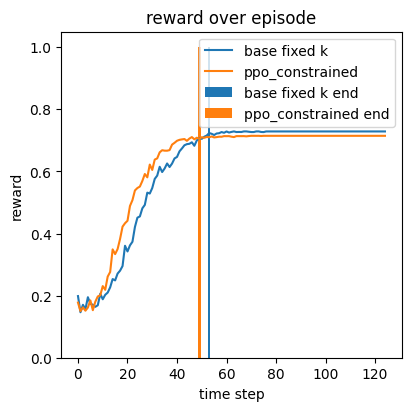

In [16]:
ppo_c = UNet()
ppo_c.load_state_dict(torch.load("models/ppo_k_policy.torch"))
simulate_search({'base fixed k':base_rand_explore_policy, 'ppo_constrained':dynamic_rand_explore_policy(ppo_c.forward_scalar)})